## 📄 Dataset Description

- **Dataset**: Mini Speech Commands (Google)
- **Task**: Binary speech classification — `"yes"` vs `"no"`
- **Samples**: 2,000 total (1,000 "yes", 1,000 "no")
- **Duration**: 1 second per clip, 16kHz mono WAV
- **Features Extracted**:
  - 13 MFCCs
  - 1 Spectral Centroid
  - 1 Spectral Rolloff
  - 1 Zero-Crossing Rate
  - **Total**: 16 features per sample
- **Class Distribution**: Balanced (50% yes, 50% no)


In [55]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import os
import librosa
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
from collections import Counter
import sounddevice as sd
from scipy.io.wavfile import write

### Loading Data

In [23]:
DATASET_PATH = 'Speech/mini_speech_commands'

# Labels used 
CLASSES = ['yes', 'no']

# Sample rate for consistency
SAMPLE_RATE = 16000

### Preprocessing + Features extraction function

In [24]:
# Extracting features from a single audio file
def extract_features(file_path):
    # Load audio
    y, sr = librosa.load(file_path, sr=SAMPLE_RATE)
    
    # --- Preprocessing ---

    # Noise Reduction (pre-emphasis filter to reduce noise) 
    y = librosa.effects.preemphasis(y)

    # Silence Removal
    y, _ = librosa.effects.trim(y, top_db=20)

    # Normalization
    y = librosa.util.normalize(y)

    # --- Feature Extraction ---

    # MFCCs (13 coefficients)
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)

    # Spectral Centroid
    spec_centroid = librosa.feature.spectral_centroid(y=y, sr=sr)

    # Spectral Rolloff
    spec_rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)

    # Zero-Crossing Rate
    zcr = librosa.feature.zero_crossing_rate(y)

    # Combine features (mean across time axis)
    features = np.hstack([
        np.mean(mfccs, axis=1),              # 13
        np.mean(spec_centroid),             # 1
        np.mean(spec_rolloff),              # 1
        np.mean(zcr)                        # 1
    ])

    scaler = StandardScaler()
    features = scaler.fit_transform(features.reshape(-1, 1)).flatten()

    return features

### Preparing Data

In [25]:
def prepare_dataset(dataset_path, classes):
    X, y = [], []

    for label in classes:
        folder = os.path.join(dataset_path, label)
        for file_name in os.listdir(folder):
            file_path = os.path.join(folder, file_name)
            try:
                features = extract_features(file_path)
                X.append(features)
                y.append(label)
            except Exception as e:
                print(f"Error processing {file_path}: {e}")

    return np.array(X), np.array(y)

X, y = prepare_dataset(DATASET_PATH, CLASSES)
print("Feature matrix shape:", X.shape)
print("Labels shape:", y.shape)

Feature matrix shape: (2000, 16)
Labels shape: (2000,)


### Label Encoding

In [26]:
le = LabelEncoder()
y_encoded = le.fit_transform(y)  # yes → 1, no → 0
print("Encoded labels:", np.unique(y_encoded, return_counts=True))

Encoded labels: (array([0, 1]), array([1000, 1000]))


### Train Test Split

In [27]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)
print("Train samples:", X_train.shape[0])
print("Test samples:", X_test.shape[0])

Train samples: 1600
Test samples: 400


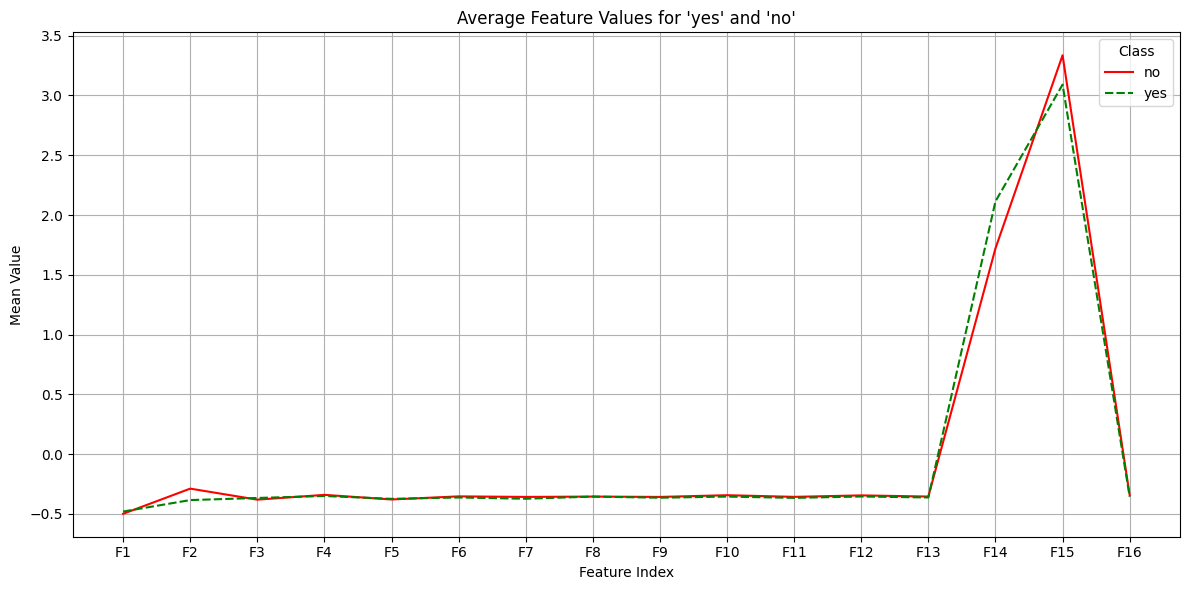

In [28]:
df = pd.DataFrame(X, columns=[f'F{i+1}' for i in range(X.shape[1])])
df['label'] = y

# Compute mean feature vector for each class
mean_features = df.groupby('label').mean().T
mean_features.columns = ['no', 'yes']  # or use: le.classes_

# Plotting
plt.figure(figsize=(12, 6))
sns.lineplot(data=mean_features, palette=['red', 'green'])
plt.title("Average Feature Values for 'yes' and 'no'")
plt.xlabel("Feature Index")
plt.ylabel("Mean Value")
plt.xticks(ticks=range(16), labels=[f'F{i+1}' for i in range(16)])
plt.grid(True)
plt.legend(title='Class')
plt.tight_layout()
plt.show()

In [51]:
def naive_bayes(X_train, y_train, X_test):
    classes = np.unique(y_train)
    predictions = []
    means = {}
    vars_ = {}
    priors = {}

    for c in classes:
        X_c = X_train[y_train == c]
        means[c] = np.mean(X_c, axis=0)
        vars_[c] = np.var(X_c, axis=0) + 1e-6
        priors[c] = len(X_c) / len(X_train)

    for x in X_test:
        probs = {}
        for c in classes:
            mean = means[c]
            var = vars_[c]
            prior = priors[c]

            exponent = np.exp(-((x - mean) ** 2) / (2 * var))
            pdf = (1 / np.sqrt(2 * np.pi * var)) * exponent
            likelihood = np.prod(pdf)

            probs[c] = prior * likelihood

        prediction = max(probs, key=probs.get)
        predictions.append(prediction)

    return np.array(predictions)

### Logistic Regression

In [ ]:
class Logistic_Regression:
    def __init__(self, learning_rate=0.01, n_iterations=1000):
        self.learning_rate = learning_rate
        self.n_iterations = n_iterations
        self.weights = None
        self.bias = None

    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.weights = np.zeros(n_features)
        self.bias = 0

        for _ in range(self.n_iterations):
            linear_model = np.dot(X, self.weights) + self.bias
            y_predicted = self.sigmoid(linear_model)

            dw = (1 / n_samples) * np.dot(X.T, (y_predicted - y))
            db = (1 / n_samples) * np.sum(y_predicted - y)

            self.weights -= self.learning_rate * dw
            self.bias -= self.learning_rate * db

    def predict_proba(self, X):
        linear_model = np.dot(X, self.weights) + self.bias
        return self.sigmoid(linear_model)

    def predict(self, X):
        y_probs = self.predict_proba(X)
        return np.where(y_probs >= 0.5, 1, 0)


In [54]:
y_pred = naive_bayes(X_train, y_train, X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred, pos_label=1))
print("Recall:", recall_score(y_test, y_pred, pos_label=1))
print("F1 Score:", f1_score(y_test, y_pred, pos_label=1))
print('-----------------------------------------------------------')

log_reg = Logistic_Regression()
log_reg.fit(X_train, y_train)

y_pred_log = log_reg.predict(X_test)

print("Logistic Regression Results:")
print("Accuracy:", accuracy_score(y_test, y_pred_log))
print("Precision:", precision_score(y_test, y_pred_log, pos_label=1))
print("Recall:", recall_score(y_test, y_pred_log, pos_label=1))
print("F1 Score:", f1_score(y_test, y_pred_log, pos_label=1))

Accuracy: 0.92
Precision: 0.8818181818181818
Recall: 0.97
F1 Score: 0.9238095238095239
-----------------------------------------------------------
Logistic Regression Results:
Accuracy: 0.9275
Precision: 0.8976744186046511
Recall: 0.965
F1 Score: 0.9301204819277108


In [56]:
def bagging_ensemble(X_train, y_train, X_test, model_type, n_estimators=10):
    all_preds = []

    for i in range(n_estimators):
      
        X_sample, y_sample = resample(X_train, y_train, replace=True)

        if model_type == "naive":
            preds = naive_bayes(X_sample, y_sample, X_test)
        elif model_type == "logistic":
            clf = LogisticRegression()
            clf.fit(X_sample, y_sample)
            preds = clf.predict(X_test)

        all_preds.append(preds)

    all_preds = np.array(all_preds).T
    

    final_preds = []
    for preds in all_preds:
        vote = Counter(preds).most_common(1)[0][0]
        final_preds.append(vote)

    return np.array(final_preds)

In [57]:
y_pred_bag_naive = bagging_ensemble(X_train, y_train, X_test, model_type="naive", n_estimators=10)
y_pred_bag_log = bagging_ensemble(X_train, y_train, X_test, model_type="logistic", n_estimators=10)

print("Bagged Naïve Bayes Performance:")
print("Accuracy :", accuracy_score(y_test, y_pred_bag_naive))
print("Precision:", precision_score(y_test, y_pred_bag_naive, average='binary'))
print("Recall   :", recall_score(y_test, y_pred_bag_naive, average='binary'))
print("F1 Score :", f1_score(y_test, y_pred_bag_naive, average='binary'))

print("Bagged Logistic Regression Performance:")
print("Accuracy :", accuracy_score(y_test, y_pred_bag_log))
print("Precision:", precision_score(y_test, y_pred_bag_log, average='binary'))
print("Recall   :", recall_score(y_test, y_pred_bag_log, average='binary'))
print("F1 Score :", f1_score(y_test, y_pred_bag_log, average='binary'))

Bagged Naïve Bayes Performance:
Accuracy : 0.9275
Precision: 0.8904109589041096
Recall   : 0.975
F1 Score : 0.9307875894988067
Bagged Logistic Regression Performance:
Accuracy : 0.9375
Precision: 0.9146919431279621
Recall   : 0.965
F1 Score : 0.9391727493917275


In [58]:
# List available audio devices
print(sd.query_devices())

   0 Microsoft Sound Mapper - Input, MME (2 in, 0 out)
*  1 Headset Microphone (HyperX Virt, MME (2 in, 0 out)
   2 Microphone (Iriun Webcam), MME (2 in, 0 out)
   3 Microsoft Sound Mapper - Output, MME (0 in, 2 out)
   4 Headset Earphone (HyperX Virtua, MME (0 in, 2 out)
   5 2 - LC27RG50 (AMD High Definiti, MME (0 in, 2 out)
   6 Primary Sound Capture Driver, Windows DirectSound (2 in, 0 out)
   7 Headset Microphone (HyperX Virtual Surround Sound), Windows DirectSound (2 in, 0 out)
   8 Microphone (Iriun Webcam), Windows DirectSound (2 in, 0 out)
   9 Primary Sound Driver, Windows DirectSound (0 in, 2 out)
  10 Headset Earphone (HyperX Virtual Surround Sound), Windows DirectSound (0 in, 2 out)
  11 2 - LC27RG50 (AMD High Definition Audio Device), Windows DirectSound (0 in, 2 out)
  12 Headset Earphone (HyperX Virtual Surround Sound), Windows WASAPI (0 in, 2 out)
  13 2 - LC27RG50 (AMD High Definition Audio Device), Windows WASAPI (0 in, 2 out)
  14 Headset Microphone (HyperX Virtual 

In [48]:
# Choose the device you want to use 
sd.default.device = 1

In [49]:
fs = 16000  
duration = 3  
print("Recording...")

recording = sd.rec(int(duration * fs), samplerate=fs, channels=1)
sd.wait()  

write("test_voice.wav", fs, recording) 
print("Recording saved as test_voice.wav")

Recording...
Recording saved as test_voice.wav


In [50]:
features = extract_features("test_voice.wav")
naive_bayes_prediction = naive_bayes(X_train, y_train, features.reshape(1, -1))
print("Naive Bayes prediction:", naive_bayes_prediction)
logistic_prediction = log_reg.predict(features.reshape(1, -1))
print("Logistic Regression prediction:", logistic_prediction)

Naive Bayes prediction: [1]
Logistic Regression prediction: [0]
